In [2]:
import os, sys, csv
from nilearn import masking
import nibabel as nb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
import pandas as pd
from nilearn import plotting
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import gridspec
import multiprocessing
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# get values (embedding and concordance) of gray matter voxels
# get lesioned voxel's embedding values

def get_vectors(data_dir,
                subject_id,
                concordance_file,
                comp_file,
                gmask_file,
                lesion_file):

    conc_file   = os.path.join(data_dir, subject_id, 
                               concordance_file)
    gm_file     = os.path.join(data_dir, subject_id, 
                               gmask_file)
    lesOnGMmask = os.path.join(data_dir, subject_id, 
                               lesion_file)

    COMP     = np.array(nb.load(comp_file).get_data())
    CONCOR   = np.array(nb.load(conc_file).get_data())
    lesion   = np.array(nb.load(lesOnGMmask).get_data())
    ##print "AAAA", lesion.sum()
    gm_mask = nb.load(gm_file).get_data()
    x    = np.where(gm_mask==1)[0]
    y    = np.where(gm_mask==1)[1]
    z    = np.where(gm_mask==1)[2]

    comp_vec = COMP[x,y,z]
    conc_vec = CONCOR[x,y,z]

    # get lesion values sitting along the component
    lesOnComp = masking.apply_mask(comp_file, lesOnGMmask)
    
    les_vec   = lesOnComp.reshape((len(lesOnComp), 1))
    
    return conc_vec, comp_vec, gm_mask, les_vec
    

In [4]:
def gradient_bins(conc_vec, 
                  comp_vec, 
                  gm_mask, 
                  les_vec,
                  subject_id,
                  bins):

    a     = comp_vec.copy()
    df    = pd.DataFrame()
    concs = []
    lesCo = np.zeros(bins)
    result= {}

    # find indexes in gradient from lowest to highest
    data_argsort = np.argsort(a)[::-1]
    data_argsort = np.flipud(data_argsort)

    # given bin number, how many elements sitting in each bin 
    steps        = int((1/float(bins))*len(a))
   
    # loop from lowest to highest bin
    for thisp in range(bins):    
        
        # index is indices of elements sitting in each bin
        index = data_argsort[thisp*steps :(thisp+1)*steps+1] 
        bmin = a[index].min()
        bmax = a[index].max()
        tmp  = conc_vec[index].mean()
        concs.append(tmp)
        
        #print les_vec
        for i in range(len(les_vec)):
            if bmin < les_vec[i] and les_vec[i] < bmax:
                 #print thisp,  bmin, bmax, les_vec[i]
                 lesCo[thisp] = 1

    df[subject_id] = concs
    df[subject_id + '_les'] = lesCo

    # get delta concordance
    mu_unaf = np.array(concs)[np.where(lesCo == 0)].mean()
    mu_af   = np.array(concs)[np.where(lesCo == 1)].mean()
    delta   = mu_unaf - mu_af
    result[subject_id] = delta
    
    return df, result

run for a single subject

# divide patients into two groups

In [2]:
# get behavior
file_beh  = '/data/pt_mar006/documents/all_sd_datasummary_STEIGLITZ.xlsx'
dtype_dic = {'patient number': 'float'}

db = pd.read_excel(file_beh, #index_col='patient number',
                   converters={'patient number': lambda x: str(x)})
db = db.set_index("study_id")

subject_behav = db.index


# create data frame
df_behav = pd.DataFrame(index=subject_behav, 
                        columns=['nihss_adm',
                                 'delta_nihss',
                                 'abs_delta_nihss',
                                 'nihss_dis'])
        
for subject_id in subject_behav:
    
    if type(db.ix[subject_id]['NIHSS_admission']) != unicode:
        df_behav.ix[subject_id]['nihss_adm'] = db.ix[subject_id]['NIHSS_admission']
    
    if type(db.ix[subject_id]['NIHSS_discharge']) != unicode:
        df_behav.ix[subject_id]['nihss_dis'] = db.ix[subject_id]['NIHSS_discharge']

    if type(db.ix[subject_id]['NIHSS_discharge']) != unicode :
        if type(db.ix[subject_id]['NIHSS_admission']) != unicode :
            
            A = db.ix[subject_id]['NIHSS_discharge']
            B = db.ix[subject_id]['NIHSS_admission']
            
            delta_nihss = B - A
            
            df_behav.ix[subject_id]['delta_nihss'] = delta_nihss         
            df_behav.ix[subject_id]['abs_delta_nihss'] = abs(delta_nihss)         
            
len(df_behav)

54

In [3]:
list_name    = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'
with open(list_name) as f:
    subject_list = f.read().splitlines()
len(subject_list)

28

In [4]:
dA = df_behav.ix[subject_list]

In [5]:
dA_zeros = dA[dA.delta_nihss == 0]
dA_zeros

,nihss_adm,delta_nihss,abs_delta_nihss,nihss_dis
study_id,,,,
sd10,0,0,0,0
sd14,0,0,0,0
sd33,1,0,0,1
sd36,1,0,0,1
sd39,1,0,0,1
sd42,0,0,0,0
sd43,4,0,0,4
sd45,0,0,0,0
sd48,1,0,0,1


In [6]:
dA_tmp      = dA[dA.delta_nihss != 0]
dA_nonzeros = dA_tmp[~np.isnan(dA_tmp.delta_nihss.astype(float))]
dA_nonzeros

,nihss_adm,delta_nihss,abs_delta_nihss,nihss_dis
study_id,,,,
sd02,6,5,5,1
sd05,5,2,2,3
sd08,1,1,1,0
sd13,7,7,7,0
sd16,1,1,1,0
sd17,3,1,1,2
sd21,1,1,1,0
sd25,5,5,5,0
sd28,5,3,3,2


In [7]:
my_zeros_index    = list(dA_zeros.index)
my_nonzeros_index = list(dA_nonzeros.index) 

In [8]:
my_zeros_index

['sd10',
 'sd14',
 'sd33',
 'sd36',
 'sd39',
 'sd42',
 'sd43',
 'sd45',
 'sd48',
 'sd49',
 'sd52']

In [9]:
my_nonzeros_index

['sd02',
 'sd05',
 'sd08',
 'sd13',
 'sd16',
 'sd17',
 'sd21',
 'sd25',
 'sd28',
 'sd31',
 'sd32',
 'sd35',
 'sd38',
 'sd40',
 'sd44',
 'sd46']

In [10]:
list(dA_nonzeros.index)

['sd02',
 'sd05',
 'sd08',
 'sd13',
 'sd16',
 'sd17',
 'sd21',
 'sd25',
 'sd28',
 'sd31',
 'sd32',
 'sd35',
 'sd38',
 'sd40',
 'sd44',
 'sd46']

In [13]:
all_subjects = list(pd.concat((dA_nonzeros, dA_zeros)).index)
len(all_subjects)

27

# 1st gradient

In [31]:
#bins_str = [20, 40]

bins_str  = list(np.arange(5, 101, 1))

# define empty data  frames
my_results      = pd.DataFrame(index=bins_str, columns=['mean_nonzeros',
                                                        'mean_zeros',
                                                        'diff_true',
                                                        'p_permut'])

my_results_ext  = pd.DataFrame(index=all_subjects, columns=[bins_str])

# loop over varying bin numbers
for XX in bins_str:
    
    tmp_A = []

    # loop over zeros patients
    for YY in my_zeros_index:

        data_dir     = '/data/pt_mar006/subjects_masks/'
        comp_file    = '/data/pt_mar006/subjects_group/mni3_component_1.nii.gz'
        subject_id   =  YY
        gmask_file   = 'gm_mask_no_lesion.nii.gz'
        lesion_file  = 'lesion_mask_mni_gm.nii.gz'
        concordance_file = 'conc_ccc.nii.gz'


        conc, comp, gm, lesion = get_vectors(data_dir,
                                             subject_id,
                                             concordance_file,
                                             comp_file,
                                             gmask_file,
                                             lesion_file)

        df_subj , result_subj = gradient_bins(conc, 
                                              comp, 
                                              gm, 
                                              lesion, 
                                              subject_id, 
                                              bins=XX)

        # fill in delta_CCC for each zeros patient at a single bin
        my_results_ext.ix[YY][XX] = result_subj.values()
        
        tmp_A.append(result_subj.values())

    # mean delta_CCC across zeros patient at a single bin    
    mean_my_zeros = np.array(tmp_A).mean()
    my_results.ix[XX]['mean_zeros'] = mean_my_zeros

    
    tmp_B = []
    # loop over nonzeros patients
    for ZZ in my_nonzeros_index:

        data_dir     = '/data/pt_mar006/subjects_masks/'
        comp_file    = '/data/pt_mar006/subjects_group/mni3_component_1.nii.gz'
        subject_id   =  ZZ
        gmask_file   = 'gm_mask_no_lesion.nii.gz'
        lesion_file  = 'lesion_mask_mni_gm.nii.gz'
        concordance_file = 'conc_ccc.nii.gz'


        conc, comp, gm, lesion = get_vectors(data_dir,
                                             subject_id,
                                             concordance_file,
                                             comp_file,
                                             gmask_file,
                                             lesion_file)

        df_subj , result_subj = gradient_bins(conc, 
                                              comp, 
                                              gm, 
                                              lesion, 
                                              subject_id, 
                                              bins=XX)
        
        # fill in delta_CCC for each nonzeros patient at a single bin
        my_results_ext.ix[ZZ][XX] = result_subj.values()

        tmp_B.append(result_subj.values())

    # mean delta_CCC across nonzeros patients at a single bin    
    mean_my_nonzeros = np.array(tmp_B).mean() 
    my_results.ix[XX]['mean_nonzeros'] = mean_my_nonzeros
    
    
    # true mean difference between nonzeros and zeros
    diff_real = mean_my_nonzeros - mean_my_zeros    
    
    # an empty list to be filled out with shuffled means
    diff_list = []
    i= 0
    
    # shuffling concatenated delta_CCC of zeros and nonzeros
    for i in range(10000):
        tmp       = np.concatenate((tmp_A, tmp_B), axis=0)
        np.random.shuffle(tmp)
        
        # divide into two groups
        tmp_zeros    = tmp[:len(tmp_A)]
        tmp_nonzeros = tmp[len(tmp_A):]
        # mean difference of two groups
        diff_tmp = tmp_nonzeros.mean() - tmp_zeros.mean()
        diff_list.append(diff_tmp)
        
    # how many shuffled-mean-diff exceeds the true-mean-diff
    diff_arr = np.array(diff_list)
    length   = float(len(diff_arr))
    exceednu = float(len(np.where(diff_arr > diff_real)[0]))
    p_permut = exceednu/length     
        
    print XX,  p_permut
    
    my_results.ix[XX]['diff_true'] = diff_real
    my_results.ix[XX]['p_permut']  = p_permut       


5 0.1485
6 0.2122
7 0.2078
8 0.2487
9 0.4043
10 0.2872
11 0.2913
12 0.3131
13 0.255
14 0.3135
15 0.3072
16 0.3262
17 0.3612
18 0.4319
19 0.3652
20 0.335
21 0.3427
22 0.3384
23 0.3384
24 0.347
25 0.3548
26 0.3518
27 0.3512
28 0.3817
29 0.3586
30 0.3423
31 0.322
32 0.3681
33 0.3955
34 0.3706
35 0.3544
36 0.3804
37 0.3978
38 0.3795
39 0.3832
40 0.3533
41 0.405
42 0.409
43 0.3343
44 0.3502
45 0.3689
46 0.3453
47 0.3563
48 0.3968
49 0.4155
50 0.4053
51 0.3971
52 0.3667
53 0.3546
54 0.3446
55 0.3625
56 0.3881
57 0.3996
58 0.3809
59 0.4306
60 0.3957
61 0.38
62 0.3649
63 0.3817
64 0.4007
65 0.3927
66 0.4391
67 0.3726
68 0.3725
69 0.3697
70 0.4184
71 0.3627
72 0.3917
73 0.3894
74 0.4021
75 0.406
76 0.375
77 0.3646
78 0.4149
79 0.4098
80 0.3843
81 0.3683
82 0.39
83 0.4082
84 0.4191
85 0.3738
86 0.3509
87 0.435
88 0.4042
89 0.3815
90 0.3956
91 0.4137
92 0.4081
93 0.3734
94 0.3927
95 0.4045
96 0.4078
97 0.3883
98 0.4081
99 0.379
100 0.4068


In [32]:
my_results

,mean_nonzeros,mean_zeros,diff_true,p_permut
5,0.016145,0.000812679,0.0153323,0.1485
6,0.0105161,-0.00121995,0.011736,0.2122
7,0.0115292,-0.00080125,0.0123305,0.2078
8,0.00962355,0.000358501,0.00926505,0.2487
9,0.0109722,0.00807806,0.00289411,0.4043
10,0.0107636,0.00394433,0.00681926,0.2872
11,0.0116839,0.00400709,0.00767677,0.2913
12,0.010416,0.00447242,0.00594361,0.3131
13,0.0110515,0.0026861,0.00836543,0.255
14,0.0108617,0.00469262,0.00616907,0.3135


MEAN:  0.00414827269263


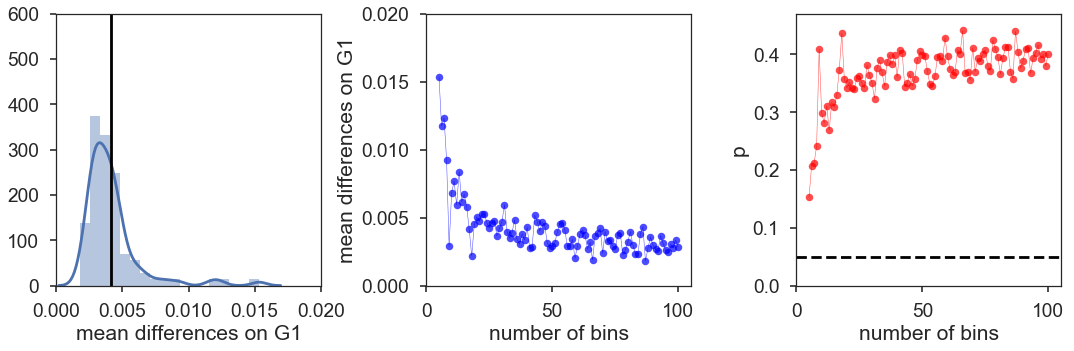

In [126]:
sns.set_context('poster', font_scale=1.2)
sns.set_style("ticks")

fig=plt.figure(figsize=(18,5))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.distplot(np.array(my_results['diff_true']).astype(float), ax=ax1)
ax1.axvline(x=np.array(my_results['diff_true']).astype(float).mean(), c='k')
ax1.set_xlabel('mean differences on G1')
ax1.set_ylim(0, 600)
ax1.set_xlim(0, 0.02)

print "MEAN: ", np.array(my_results['diff_true']).astype(float).mean()


ax2.plot(np.array(my_results.index).astype(int), 
         np.array(my_results['diff_true']).astype(float), 
         marker='.',  
         markersize=15, 
         markeredgecolor='none',
         c='b', 
         alpha=0.7,
         linestyle = 'solid',
         linewidth = 0.5)

ax2.set_ylabel('mean differences on G1')
ax2.set_xlabel('number of bins')
ax2.set_ylim(0.000, 0.0200)
ax2.set_xlim(0, 105)


ax3.plot(np.array(my_results.index).astype(int), 
         np.array(my_results['p_permut']).astype(float), 
         marker='.',  
         markersize=15, 
         markeredgecolor='none',
         c='r', 
         alpha=0.7,
         linestyle = 'solid',
         linewidth = 0.5)

ax3.set_ylabel('p')
ax3.set_xlabel('number of bins')
ax3.set_xlim(0, 105)
ax3.set_ylim(0.000, 0.47)
ax3.axhline(y=0.05, c='k', linestyle='--')

# Gradient 1

## bins up to 3000

In [2]:
filenamelist = ['/data/pt_mar006/tmpX/A_0001.xlsx',
                '/data/pt_mar006/tmpX/A_0002.xlsx',
                '/data/pt_mar006/tmpX/A_0003.xlsx', 
                '/data/pt_mar006/tmpX/A_0004.xlsx',
                '/data/pt_mar006/tmpX/A_0005.xlsx',
'/data/pt_mar006/tmpX/A_0006.xlsx',
'/data/pt_mar006/tmpX/A_0007.xlsx',
'/data/pt_mar006/tmpX/A_0008.xlsx',
'/data/pt_mar006/tmpX/A_0009.xlsx',
'/data/pt_mar006/tmpX/A_0010.xlsx',
'/data/pt_mar006/tmpX/A_0011.xlsx',
'/data/pt_mar006/tmpX/A_0012.xlsx',
'/data/pt_mar006/tmpX/A_0013.xlsx',
'/data/pt_mar006/tmpX/A_0014.xlsx',
'/data/pt_mar006/tmpX/A_0015.xlsx',
'/data/pt_mar006/tmpX/A_0016.xlsx',
'/data/pt_mar006/tmpX/A_0017.xlsx',
'/data/pt_mar006/tmpX/A_0018.xlsx',
'/data/pt_mar006/tmpX/A_0019.xlsx',
'/data/pt_mar006/tmpX/A_0020.xlsx',
'/data/pt_mar006/tmpX/A_0021.xlsx',
'/data/pt_mar006/tmpX/A_0022.xlsx',
'/data/pt_mar006/tmpX/A_0023.xlsx',
'/data/pt_mar006/tmpX/A_0024.xlsx',
'/data/pt_mar006/tmpX/A_0025.xlsx',
'/data/pt_mar006/tmpX/A_0026.xlsx',
'/data/pt_mar006/tmpX/A_0027.xlsx',
'/data/pt_mar006/tmpX/A_0028.xlsx',
'/data/pt_mar006/tmpX/A_0029.xlsx',
'/data/pt_mar006/tmpX/A_0030.xlsx']

In [3]:
dBig = []

i = 0
for filename in filenamelist:
    dTmp = pd.read_excel(filename)
    
    if i == 0:
        dBig = dTmp
    elif i != 0:
        dBig = pd.concat([dBig, dTmp])
    
    i += 1

In [5]:
len(dBig)

2996

In [4]:
dBig

,mean_nonzeros,mean_zeros,diff_true,p_permut
5,0.016145,0.000813,0.015332,0.1523
6,0.010516,-0.001220,0.011736,0.2098
7,0.011529,-0.000801,0.012330,0.2173
8,0.009624,0.000359,0.009265,0.2406
9,0.010972,0.008078,0.002894,0.4101
10,0.010764,0.003944,0.006819,0.3024
11,0.011684,0.004007,0.007677,0.2831
12,0.010416,0.004472,0.005944,0.3105
13,0.011052,0.002686,0.008365,0.2562
14,0.010862,0.004693,0.006169,0.3120


In [73]:
#dBig.to_excel('/data/pt_mar006/documents/permut_nihss_diff_grad1_3000.xlsx')

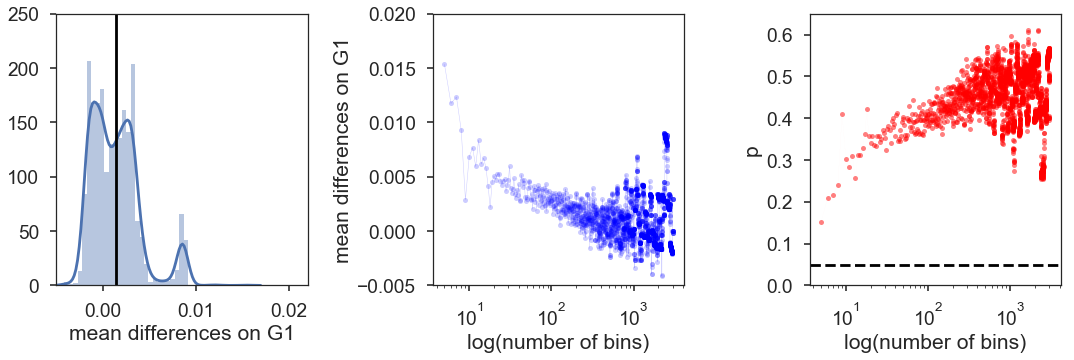

In [5]:
sns.set_context('poster', font_scale=1.2)
sns.set_style("ticks")

fig=plt.figure(figsize=(18,5))

fig.subplots_adjust(hspace=0., wspace=0.5)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


sns.distplot(np.array(dBig['diff_true']).astype(float), ax=ax1)
ax1.axvline(x=np.array(dBig['diff_true']).astype(float).mean(), c='k')
ax1.set_xlabel('mean differences on G1')
ax1.set_ylim(0, 250)
ax1.set_xlim(-0.005, 0.022)

ax2.semilogx(np.array(dBig.index).astype(int), 
         np.array(dBig['diff_true']).astype(float), 
         marker='.',  
         markersize=10, 
         markeredgecolor='none',
         c='b', 
         alpha=0.2,
         linestyle = 'solid',
         linewidth = 0.5)

ax2.set_ylabel('mean differences on G1')
ax2.set_xlabel('log(number of bins)')
ax2.set_ylim(-0.005, 0.0200)
#ax2.set_xlim(0, 105)


ax3.semilogx(np.array(dBig.index).astype(int), 
         np.array(dBig['p_permut']).astype(float), 
         marker='.',  
         markersize=10, 
         markeredgecolor='none',
         c='r', 
         alpha=0.5,
         linestyle = 'solid',
         linewidth = 0.01)

ax3.set_ylabel('p')
ax3.set_xlabel('log(number of bins)')
#ax3.set_xlim(0, 105)
ax3.set_ylim(0.000, 0.65)
ax3.axhline(y=0.05, c='k', linestyle='--')

In [7]:

print "MEAN: ", np.array(dBig['diff_true']).astype(float).mean()



MEAN:  0.00137256659737


# get variance in each of 50 bins

In [8]:
len(dBig)

2996

In [9]:
len(np.arange(5, len(dBig)-50, 50))

59

In [21]:
my_length = len(np.arange(5, len(dBig), 50))

print "number of windows: ", my_length


dVar = pd.DataFrame(index   = np.arange(1, my_length+1, 1), 
                    columns = ['bin_range', 'ave', 'std', 'var', 'p-range'])

for window_num in np.arange(0, my_length, 1):
    
    
    start_num  = window_num*50 + 5
    finish_num = (window_num+1)*50 + 5
    
    my_range = np.arange(start_num, finish_num, 1)
    
    my_std   = np.std(dBig.ix[my_range]['diff_true'])
    
    my_ave   = np.mean(dBig.ix[my_range]['diff_true'])
    
    my_var   = np.var(dBig.ix[my_range]['diff_true'])


    my_Pmin  = dBig.ix[my_range]['p_permut'].min()
    my_Pmax  = dBig.ix[my_range]['p_permut'].max()
    my_Pstr  = str(my_Pmin) + '-' + str(my_Pmax)
    

    if window_num  != 59:
        my_strin = (str(my_range[0]) + '-' + str(my_range[-1]))    
    
    elif window_num ==59:
        my_strin = (str(my_range[0]) + '-' + str(dBig.index[-1]))
    
    dVar.ix[window_num+1]['bin_range'] = my_strin
    dVar.ix[window_num+1]['ave']       = my_ave
    dVar.ix[window_num+1]['std']       = my_std
    dVar.ix[window_num+1]['var']       = my_var
    dVar.ix[window_num+1]['p-range']   = my_Pstr
    
    
print 'minimum : ', dVar['var'].min(), 'index: ', dVar.index[dVar['var'] == dVar['var'].min()]


number of windows:  60
minimum :  2.50214969118e-09 index:  Int64Index([59], dtype='int64')


2.719849554522704e-06

In [19]:
dVar


,bin_range,ave,std,var,p-range
1,5-54,0.00509326,0.00250503,6.27519e-06,0.1523-0.4209
2,55-104,0.00308488,0.000661105,4.3706e-07,0.3587-0.4436
3,105-154,0.00241612,0.000724388,5.24737e-07,0.3629-0.4712
4,155-204,0.00197468,0.000716098,5.12797e-07,0.3811-0.4767
5,205-254,0.0014529,0.000827907,6.8543e-07,0.3907-0.5121
6,255-304,0.00119939,0.00101133,1.02279e-06,0.3827-0.5416
7,305-354,0.00127057,0.00100172,1.00344e-06,0.3752-0.53
8,355-404,0.000445062,0.000921685,8.49504e-07,0.4148-0.5407
9,405-454,0.000634314,0.0010757,1.15714e-06,0.3965-0.5444
10,455-504,0.000836044,0.00103006,1.06102e-06,0.3918-0.5276


In [22]:
#dVar.to_excel('/data/pt_mar006/documents/permut_nihss_diff_grad1_3000_std_v2.xlsx')

# Gradient 2

# bins up to 3000 

In [26]:
filenamelist = ['/data/pt_mar006/tmpX/B_0001.xlsx',
                '/data/pt_mar006/tmpX/B_0002.xlsx',
                '/data/pt_mar006/tmpX/B_0003.xlsx', 
                '/data/pt_mar006/tmpX/B_0004.xlsx',
                '/data/pt_mar006/tmpX/B_0005.xlsx',
'/data/pt_mar006/tmpX/B_0006.xlsx',
'/data/pt_mar006/tmpX/B_0007.xlsx',
'/data/pt_mar006/tmpX/B_0008.xlsx',
'/data/pt_mar006/tmpX/B_0009.xlsx',
'/data/pt_mar006/tmpX/B_0010.xlsx',
'/data/pt_mar006/tmpX/B_0011.xlsx',
'/data/pt_mar006/tmpX/B_0012.xlsx',
'/data/pt_mar006/tmpX/B_0013.xlsx',
'/data/pt_mar006/tmpX/B_0014.xlsx',
'/data/pt_mar006/tmpX/B_0015.xlsx',
'/data/pt_mar006/tmpX/B_0016.xlsx',
'/data/pt_mar006/tmpX/B_0017.xlsx',
'/data/pt_mar006/tmpX/B_0018.xlsx',
'/data/pt_mar006/tmpX/B_0019.xlsx',
'/data/pt_mar006/tmpX/B_0020.xlsx',
'/data/pt_mar006/tmpX/B_0021.xlsx',
'/data/pt_mar006/tmpX/B_0022.xlsx',
'/data/pt_mar006/tmpX/B_0023.xlsx',
'/data/pt_mar006/tmpX/B_0024.xlsx',
'/data/pt_mar006/tmpX/B_0025.xlsx',
'/data/pt_mar006/tmpX/B_0026.xlsx',
'/data/pt_mar006/tmpX/B_0027.xlsx',
'/data/pt_mar006/tmpX/B_0028.xlsx',
'/data/pt_mar006/tmpX/B_0029.xlsx',
'/data/pt_mar006/tmpX/B_0030.xlsx']

In [27]:
dBig = []

i = 0
for filename in filenamelist:
    dTmp = pd.read_excel(filename)
    
    if i == 0:
        dBig = dTmp
    elif i != 0:
        dBig = pd.concat([dBig, dTmp])
    
    i += 1

In [28]:
len(dBig)

2996

In [29]:
#dBig.to_excel('/data/pt_mar006/documents/permut_nihss_diff_grad2_3000.xlsx')

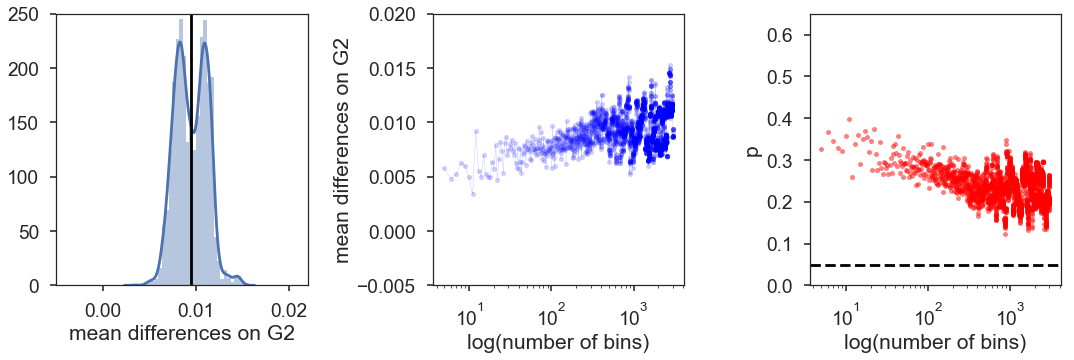

In [30]:
sns.set_context('poster', font_scale=1.2)
sns.set_style("ticks")

fig=plt.figure(figsize=(18,5))

fig.subplots_adjust(hspace=0., wspace=0.5)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


sns.distplot(np.array(dBig['diff_true']).astype(float), ax=ax1)
ax1.axvline(x=np.array(dBig['diff_true']).astype(float).mean(), c='k')
ax1.set_xlabel('mean differences on G2')
ax1.set_ylim(0, 250)
ax1.set_xlim(-0.005, 0.022)

ax2.semilogx(np.array(dBig.index).astype(int), 
         np.array(dBig['diff_true']).astype(float), 
         marker='.',  
         markersize=10, 
         markeredgecolor='none',
         c='b', 
         alpha=0.2,
         linestyle = 'solid',
         linewidth = 0.5)

ax2.set_ylabel('mean differences on G2')
ax2.set_xlabel('log(number of bins)')
ax2.set_ylim(-0.005, 0.0200)
#ax2.set_xlim(0, 105)


ax3.semilogx(np.array(dBig.index).astype(int), 
         np.array(dBig['p_permut']).astype(float), 
         marker='.',  
         markersize=10, 
         markeredgecolor='none',
         c='r', 
         alpha=0.5,
         linestyle = 'solid',
         linewidth = 0.01)

ax3.set_ylabel('p')
ax3.set_xlabel('log(number of bins)')
#ax3.set_xlim(0, 105)
ax3.set_ylim(0.000, 0.65)
ax3.axhline(y=0.05, c='k', linestyle='--')

In [32]:

print "MEAN: ", np.array(dBig['diff_true']).astype(float).mean()



MEAN:  0.00950553794002


# get the mean variance ...

In [33]:
len(np.arange(5, len(dBig)-50, 50))

59

In [34]:
my_length = len(np.arange(5, len(dBig), 50))

print "number of windows: ", my_length


dVar = pd.DataFrame(index   = np.arange(1, my_length+1, 1), 
                    columns = ['bin_range', 'ave', 'std', 'var', 'p-range'])

for window_num in np.arange(0, my_length, 1):
    
    
    start_num  = window_num*50 + 5
    finish_num = (window_num+1)*50 + 5
    
    my_range = np.arange(start_num, finish_num, 1)
    
    my_std   = np.std(dBig.ix[my_range]['diff_true'])
    
    my_ave   = np.mean(dBig.ix[my_range]['diff_true'])
    
    my_var   = np.var(dBig.ix[my_range]['diff_true'])


    my_Pmin  = dBig.ix[my_range]['p_permut'].min()
    my_Pmax  = dBig.ix[my_range]['p_permut'].max()
    my_Pstr  = str(my_Pmin) + '-' + str(my_Pmax)
    

    if window_num  != 59:
        my_strin = (str(my_range[0]) + '-' + str(my_range[-1]))    
    
    elif window_num ==59:
        my_strin = (str(my_range[0]) + '-' + str(dBig.index[-1]))
    
    dVar.ix[window_num+1]['bin_range'] = my_strin
    dVar.ix[window_num+1]['ave']       = my_ave
    dVar.ix[window_num+1]['std']       = my_std
    dVar.ix[window_num+1]['var']       = my_var
    dVar.ix[window_num+1]['p-range']   = my_Pstr
    
    
print 'minimum : ', dVar['var'].min(), 'index: ', dVar.index[dVar['var'] == dVar['var'].min()]


number of windows:  60
minimum :  8.08646738038e-09 index:  Int64Index([58], dtype='int64')


In [35]:
dVar

,bin_range,ave,std,var,p-range
1,5-54,0.00668112,0.0012719,1.61772e-06,0.2591-0.3981
2,55-104,0.00762827,0.000788289,6.214e-07,0.2328-0.3389
3,105-154,0.00802911,0.000802253,6.4361e-07,0.2233-0.3379
4,155-204,0.00832281,0.000730796,5.34063e-07,0.2268-0.3058
5,205-254,0.00877704,0.000769561,5.92225e-07,0.2088-0.3077
6,255-304,0.00866189,0.000941185,8.85829e-07,0.2014-0.3052
7,305-354,0.00957153,0.000994919,9.89863e-07,0.1906-0.2848
8,355-404,0.00971351,0.00105459,1.11216e-06,0.1863-0.2734
9,405-454,0.00998047,0.000951023,9.04444e-07,0.1671-0.2622
10,455-504,0.00910847,0.000986354,9.72895e-07,0.1921-0.3045


# Gradient 3

# bins up to 3000

In [37]:
filenamelist = ['/data/pt_mar006/tmpX/C_0001.xlsx',
                '/data/pt_mar006/tmpX/C_0002.xlsx',
                '/data/pt_mar006/tmpX/C_0003.xlsx', 
                '/data/pt_mar006/tmpX/C_0004.xlsx',
                '/data/pt_mar006/tmpX/C_0005.xlsx',
'/data/pt_mar006/tmpX/C_0006.xlsx',
'/data/pt_mar006/tmpX/C_0007.xlsx',
'/data/pt_mar006/tmpX/C_0008.xlsx',
'/data/pt_mar006/tmpX/C_0009.xlsx',
'/data/pt_mar006/tmpX/C_0010.xlsx',
'/data/pt_mar006/tmpX/C_0011.xlsx',
'/data/pt_mar006/tmpX/C_0012.xlsx',
'/data/pt_mar006/tmpX/C_0013.xlsx',
'/data/pt_mar006/tmpX/C_0014.xlsx',
'/data/pt_mar006/tmpX/C_0015.xlsx',
'/data/pt_mar006/tmpX/C_0016.xlsx',
'/data/pt_mar006/tmpX/C_0017.xlsx',
'/data/pt_mar006/tmpX/C_0018.xlsx',
'/data/pt_mar006/tmpX/C_0019.xlsx',
'/data/pt_mar006/tmpX/C_0020.xlsx',
'/data/pt_mar006/tmpX/C_0021.xlsx',
'/data/pt_mar006/tmpX/C_0022.xlsx',
'/data/pt_mar006/tmpX/C_0023.xlsx',
'/data/pt_mar006/tmpX/C_0024.xlsx',
'/data/pt_mar006/tmpX/C_0025.xlsx',
'/data/pt_mar006/tmpX/C_0026.xlsx',
'/data/pt_mar006/tmpX/C_0027.xlsx',
'/data/pt_mar006/tmpX/C_0028.xlsx',
'/data/pt_mar006/tmpX/C_0029.xlsx',
'/data/pt_mar006/tmpX/C_0030.xlsx']

In [38]:
dBig = []

i = 0
for filename in filenamelist:
    dTmp = pd.read_excel(filename)
    
    if i == 0:
        dBig = dTmp
    elif i != 0:
        dBig = pd.concat([dBig, dTmp])
    
    i += 1

In [39]:
len(dBig)

2996

In [40]:
#dBig.to_excel('/data/pt_mar006/documents/permut_nihss_diff_grad3_3000.xlsx')

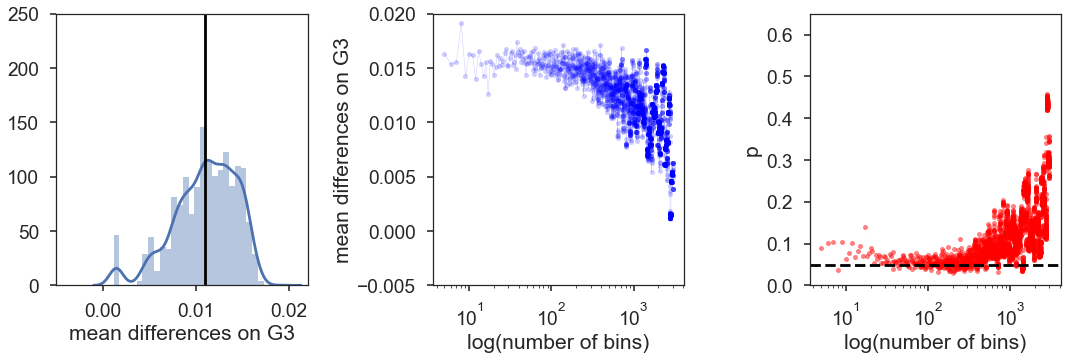

In [41]:
sns.set_context('poster', font_scale=1.2)
sns.set_style("ticks")

fig=plt.figure(figsize=(18,5))

fig.subplots_adjust(hspace=0., wspace=0.5)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


sns.distplot(np.array(dBig['diff_true']).astype(float), ax=ax1)
ax1.axvline(x=np.array(dBig['diff_true']).astype(float).mean(), c='k')
ax1.set_xlabel('mean differences on G3')
ax1.set_ylim(0, 250)
ax1.set_xlim(-0.005, 0.022)

ax2.semilogx(np.array(dBig.index).astype(int), 
         np.array(dBig['diff_true']).astype(float), 
         marker='.',  
         markersize=10, 
         markeredgecolor='none',
         c='b', 
         alpha=0.2,
         linestyle = 'solid',
         linewidth = 0.5)

ax2.set_ylabel('mean differences on G3')
ax2.set_xlabel('log(number of bins)')
ax2.set_ylim(-0.005, 0.0200)
#ax2.set_xlim(0, 105)


ax3.semilogx(np.array(dBig.index).astype(int), 
         np.array(dBig['p_permut']).astype(float), 
         marker='.',  
         markersize=10, 
         markeredgecolor='none',
         c='r', 
         alpha=0.5,
         linestyle = 'solid',
         linewidth = 0.01)

ax3.set_ylabel('p')
ax3.set_xlabel('log(number of bins)')
#ax3.set_xlim(0, 105)
ax3.set_ylim(0.000, 0.65)
ax3.axhline(y=0.05, c='k', linestyle='--')

In [43]:

print "MEAN: ", np.array(dBig['diff_true']).astype(float).mean()



MEAN:  0.0110108861379


# get variance in each of 50 bins

In [45]:
len(np.arange(5, len(dBig)-50, 50))

59

In [48]:
my_length = len(np.arange(5, len(dBig), 50))

print "number of windows: ", my_length


dVar = pd.DataFrame(index   = np.arange(1, my_length+1, 1), 
                    columns = ['bin_range', 'ave', 'std', 'var', 'p-range'])

for window_num in np.arange(0, my_length, 1):
    
    
    start_num  = window_num*50 + 5
    finish_num = (window_num+1)*50 + 5
    
    my_range = np.arange(start_num, finish_num, 1)
    
    my_std   = np.std(dBig.ix[my_range]['diff_true'])
    
    my_ave   = np.mean(dBig.ix[my_range]['diff_true'])
    
    my_var   = np.var(dBig.ix[my_range]['diff_true'])


    my_Pmin  = dBig.ix[my_range]['p_permut'].min()
    my_Pmax  = dBig.ix[my_range]['p_permut'].max()
    my_Pstr  = str(my_Pmin) + '-' + str(my_Pmax)
    

    if window_num  != 59:
        my_strin = (str(my_range[0]) + '-' + str(my_range[-1]))    
    
    elif window_num ==59:
        my_strin = (str(my_range[0]) + '-' + str(dBig.index[-1]))
    
    dVar.ix[window_num+1]['bin_range'] = my_strin
    dVar.ix[window_num+1]['ave']       = my_ave
    dVar.ix[window_num+1]['std']       = my_std
    dVar.ix[window_num+1]['var']       = my_var
    dVar.ix[window_num+1]['p-range']   = my_Pstr
    
    
print 'minimum : ', dVar['var'].min(), 'index: ', dVar.index[dVar['var'] == dVar['var'].min()]


number of windows:  60
minimum :  6.91186443593e-10 index:  Int64Index([58], dtype='int64')


In [49]:
dVar


,bin_range,ave,std,var,p-range
1,5-54,0.015717,0.000968183,9.37379e-07,0.0363-0.1391
2,55-104,0.0154556,0.000682092,4.65249e-07,0.0389-0.0764
3,105-154,0.0151576,0.000882565,7.78921e-07,0.0326-0.0877
4,155-204,0.015049,0.000841542,7.08192e-07,0.0297-0.0927
5,205-254,0.0147844,0.000888177,7.88859e-07,0.0335-0.1102
6,255-304,0.014799,0.000742794,5.51743e-07,0.0345-0.0789
7,305-354,0.0143575,0.000990356,9.80805e-07,0.0369-0.0925
8,355-404,0.0137415,0.00122813,1.50831e-06,0.0344-0.1101
9,405-454,0.013936,0.00104171,1.08516e-06,0.0476-0.1233
10,455-504,0.0134267,0.00125993,1.58741e-06,0.0386-0.1201


In [50]:
#dVar.to_excel('/data/pt_mar006/documents/permut_nihss_diff_grad3_3000_std_v2.xlsx')